# Figure 4: Lyapunov Timescale in the Solar System

This notebook recreates Figure 4 in Rein & Tamayo 2017. We ran 24 simulations of the Solar System for three hundred million years. In each simulation the position of Mercury was perturbed by one meter. In this notebook, we calculate the Lyapunov timescale for the inner Solar System by calculating the divergence between these simulations. This notebook assumes that the SimulationArchives have already been downloaded and the shared libary for general relativistic corrections has been compiled (see other notebooks). 

In [2]:
import rebound, glob
from IPython.display import display
print(rebound.__build__,rebound.__githash__)
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
from ctypes import cdll, byref
cgr = cdll.LoadLibrary("force.so")
def setup(sim):
    sim.additional_forces=cgr.gr_force

Apr 15 2017 21:13:57 c7e77b838d033099915dd47d9f2d7a6479daf788


First, let us load all SimulationArchives.

In [3]:
sasJANUS = []
for f in glob.glob("datafiles/*.bin"):
    sasJANUS.append(rebound.SimulationArchive(f,setup=setup))

/Users/rein/git/rebound/rebound/simulationarchive.py:63: RuntimeWarning: Binary file was saved with a different version of REBOUND. Binary format might have changed.
  warnings.warn(BINARY_WARNINGS[1][0], RuntimeWarning)


Next, we calculate the eccentricity at each snapshot. 

In [4]:
N = min([len(sa) for sa in sasJANUS])
tmin = 0
tmax = sasJANUS[0][N-1].t
dataJt = np.zeros((len(sasJANUS),N))

for k,sa in enumerate(sasJANUS):
    for i in range(N):
        dataJt[k][i] = sa[i].particles[1].e

We then perform an averaging procedure on the eccentricity over `Navg` neighbouring snapshots. This averages out non-secular contributions to the eccentricity and helps us measure the Lyapunov timescale more accurately.

In [5]:
Navg = 100  
Nplot = N//Navg
Ntrim = Nplot*Navg
dataJ = np.average(dataJt[:,:Ntrim].reshape((24,Nplot,Navg)),axis=2)
times = np.linspace(tmin, tmax,Nplot,endpoint=False) #sa.tmax, 300)

Now we can calculate the difference between the averaged eccentricity of Mercury in the simulations.

In [7]:
d = np.zeros(dataJ.shape)
for k in range(len(sasJANUS)):
    d[k] = np.abs(dataJ[k]-dataJ[(k+1)%24])

And finally plot the figure:

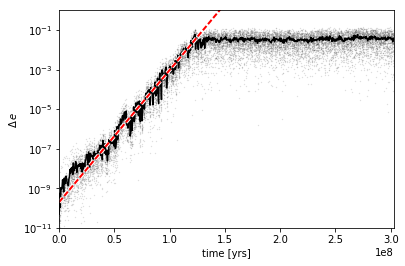

In [8]:
f, (ax1) = plt.subplots(1,1, sharey=True,figsize=(6, 4))

ax1.set_ylim([1e-11,1e0])
ax1.set_xlim([0, tmax/2/np.pi])
ax1.set_yscale("log")
ax1.set_xlabel("time [yrs]")
ax1.set_ylabel("$\Delta \,e$")
ax1.plot(times/2/np.pi,np.mean(d,axis=0),color="black")    
ax1.plot(times/2/np.pi,2e-10*np.exp(times/(2.*np.pi*6.5e6)),"--",lw=2,color="red",path_effects=[PathEffects.withStroke(linewidth=4, foreground="w")])    
for k in range(len(sasJANUS)):
    ax1.scatter(times/2/np.pi,d[k],marker=".",s=0.41,color="#555555",alpha=0.25)
plt.savefig("janus_lyapunov.pdf", format='pdf', bbox_inches='tight', pad_inches=0)